In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import datetime

In [3]:
%matplotlib inline

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16,8)
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16,8)

-------------------------------------------------------

# Data preparation and description

Let's start by simply importing the datasets and doing some initial restructuring

In [4]:
# importing data
df_rentals = pd.read_csv("DR_Data/Rentals_2019-4-2_1456.csv", parse_dates=[0,1])
df_hubav = pd.read_csv("DR_Data/Hubavailabilityaudits_2019-4-2_1535.csv", parse_dates=[3])
df_hubs = pd.read_csv("DR_Data/Hubs_2019-4-2_1201.csv", parse_dates=[0,-1])
df_searchlog1 = pd.read_csv("DR_Data/Searchlogs_2019-4-2_1234.csv", parse_dates=[-1])
df_searchlog2 = pd.read_csv("DR_Data/Searchlogs_2019-4-2_1504.csv", parse_dates=[-1])
df_weather = pd.read_csv("DR_Data/Daily_Weather.csv", parse_dates=[-1])

In [5]:
#concatenating searchlogs dataframes (the second file is a continuation of the first)
df_searchlog = pd.concat([df_searchlog1, df_searchlog2])
df_rentals= df_rentals.dropna()

----------------------------------

In [6]:
df_rentals.head(10)

,created_at,finished_at,pickup_hub_id,dropoff_hub_id,user_id
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145,2163,2449.0,108186
1,2018-03-02 09:55:18.823405,2018-03-02 16:56:35.013,2381,2381.0,113852
2,2018-03-02 14:00:10.755516,2018-03-02 17:13:08.047,1513,1513.0,113912
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544,2337,2337.0,113822
4,2018-03-02 08:51:47.459257,2018-03-02 21:18:48.813,2153,233.0,113881
5,2018-03-03 13:22:27.557683,2018-03-03 13:40:09.817,2228,941.0,109897
6,2018-03-03 11:07:59.517016,2018-03-03 16:48:21.113,1165,1165.0,113990
7,2018-03-02 07:24:39.225679,2018-03-03 18:51:56.902,2226,1898.0,62726
8,2018-03-03 08:36:11.528752,2018-03-03 21:38:57.200,1736,1736.0,113955
9,2018-03-03 15:15:14.000417,2018-03-04 11:19:27.098,2426,2262.0,114049


2) *df_hubs*: describes various characteristics for each hub such as time of creation, geo-spatial location, id, name and (eventual) time of deletion

In [7]:
df_hubs.head(10)

,created_at,latitude,longitude,id,name,deleted_at
0,2018-05-21 09:35:00.697175,48.864936,2.310624,3268,Cours la Reine,2018-05-21 16:17:24.722283
1,2018-11-26 09:06:05.590590,55.695252,12.547185,6367,Heinesgade,NaT
2,2018-06-05 12:12:28.639837,55.676916,12.564896,3642,Concert Hall Pumpehuset,2018-11-15 10:45:34.468962
3,2018-05-28 20:07:34.173984,55.668700,12.551114,3526,Saxogade,NaT
4,2018-11-08 09:36:50.440822,55.699557,12.515065,6233,GrÃ¸ndal Multicenter,NaT
5,2018-01-16 19:05:49.192033,55.682669,12.577611,2350,Egmont,NaT
6,2018-01-09 14:53:52.744834,55.668653,12.543646,2276,Vega,NaT
7,2019-03-14 11:39:00.814359,55.697218,12.584605,7148,SÃ¸nderborggade,NaT
8,2018-07-22 15:03:16.438551,55.669671,12.545824,4947,MatthÃ¦usgade,NaT
9,2019-03-20 13:50:30.943318,55.678997,12.586016,7316,Kongens Nytorv,NaT


----------------------------------

## Hubs

In what follows we aim at visualizing on the map of Copenhagen all the existing (and deleted) hubs in our dataset. In order to do this we first need to differentiate between the still existing-hubs and the deleted ones:

In [8]:
# Centered location (latitude, longitude) which we will use in all our following plots
initial_location = [55.6775757, 12.579571639999999]

In [9]:
df_deleted_hubs = df_hubs.where(pd.notna(df_hubs.deleted_at) == True).dropna()

In [10]:
df_deleted_hubs.head(10)

,created_at,latitude,longitude,id,name,deleted_at
0,2018-05-21 09:35:00.697175,48.864936,2.310624,3268.0,Cours la Reine,2018-05-21 16:17:24.722283
2,2018-06-05 12:12:28.639837,55.676916,12.564896,3642.0,Concert Hall Pumpehuset,2018-11-15 10:45:34.468962
16,2018-01-22 15:47:39.318344,55.690060,12.554953,2378.0,Solitudvej,2018-12-03 15:52:51.137800
19,2018-04-15 09:19:30.266989,55.683848,12.562526,2850.0,Finsensvej,2018-11-07 14:29:06.066021
21,2017-07-05 08:47:19.611345,55.686668,12.585904,1521.0,Adelgade,2018-12-12 18:28:38.467796
22,2018-08-13 08:41:59.812525,55.679776,12.591652,5202.0,Nyhavn 49,2018-09-07 14:09:12.782407
30,2018-07-11 11:42:08.466632,55.678256,12.602834,4791.0,Halvtolv,2018-07-27 11:30:36.790366
39,2018-11-13 10:32:50.794717,55.673889,12.589137,6262.0,Strandgade Temp,2018-12-19 09:37:34.661184
44,2018-01-22 15:58:22.227920,55.686211,12.561416,2383.0,Peblinge Dossering,2018-11-15 10:54:37.329441
47,2018-06-21 12:54:38.647923,55.697299,12.557030,4056.0,NÃ¸ddebogade,2018-11-15 11:52:11.962632


In [21]:
df_existing_hubs = df_hubs.where(pd.notna(df_hubs.deleted_at) == False).dropna(how='all')
# df_existing_hubs = df_existing_hubs[(df_existing_hubs.latitude<=55.725) & (55.625<=df_existing_hubs.latitude) & (12.5<=df_existing_hubs.longitude) & (12.65>df_existing_hubs.longitude)]

df_existing_hubs = df_existing_hubs[(df_existing_hubs.latitude<=55.72) & (55.65<=df_existing_hubs.latitude) & (12.50<=df_existing_hubs.longitude) & (12.66>df_existing_hubs.longitude)]

In [22]:
df_existing_hubs.head(10)

,created_at,latitude,longitude,id,name,deleted_at
1,2018-11-26 09:06:05.590590,55.695252,12.547185,6367.0,Heinesgade,NaT
3,2018-05-28 20:07:34.173984,55.668700,12.551114,3526.0,Saxogade,NaT
4,2018-11-08 09:36:50.440822,55.699557,12.515065,6233.0,GrÃ¸ndal Multicenter,NaT
5,2018-01-16 19:05:49.192033,55.682669,12.577611,2350.0,Egmont,NaT
6,2018-01-09 14:53:52.744834,55.668653,12.543646,2276.0,Vega,NaT
7,2019-03-14 11:39:00.814359,55.697218,12.584605,7148.0,SÃ¸nderborggade,NaT
8,2018-07-22 15:03:16.438551,55.669671,12.545824,4947.0,MatthÃ¦usgade,NaT
9,2019-03-20 13:50:30.943318,55.678997,12.586016,7316.0,Kongens Nytorv,NaT
10,2018-01-12 10:51:37.354963,55.656739,12.588744,2288.0,DR Byen,NaT
12,2018-02-19 16:37:48.343912,55.653187,12.610643,2453.0,Peder Lykkes Vej,NaT


Ok, so now we are ready to plot the hubs on the map differentiating the existing (in blue) from the deleted (in red) 

In [23]:
# Getting latitude-longitude locations for all the hubs
existing_locations = df_existing_hubs.iloc[:, 1:3].values.tolist()
del_hub_locations = df_deleted_hubs.iloc[:, 1:3].values.tolist()

(142, 299)


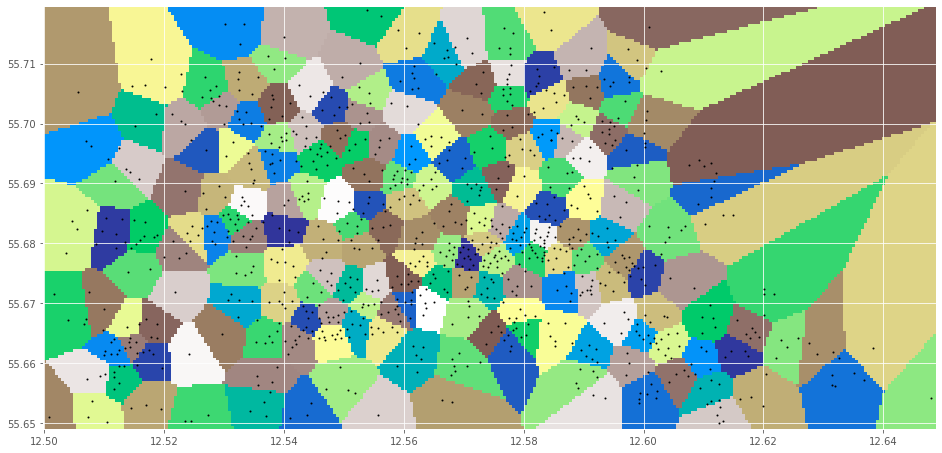

In [24]:
from sklearn.cluster import KMeans

n_superhubs = 200#df_existing_hubs.id.nunique()
margin = 0.001

# Preprocessing (flip and rotate 90deg clockwise (mirror in y=x, change x by y))
existing_locations_arr = np.array(existing_locations)
existing_locations_arr[:,[0,1]] = existing_locations_arr[:,[1,0]]


kmeans = KMeans(init='k-means++', n_clusters=n_superhubs, n_init=10)
kmeans.fit(existing_locations_arr)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .0005     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = existing_locations_arr[:, 0].min() - margin, existing_locations_arr[:, 0].max() + margin
y_min, y_max = existing_locations_arr[:, 1].min() - margin, existing_locations_arr[:, 1].max() + margin
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
print(Z.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.terrain,
           aspect='equal', origin='lower')
centroids_list = kmeans.cluster_centers_

plt.plot(existing_locations_arr[:, 0], existing_locations_arr[:, 1], 'k.', markersize=2)

In [25]:
hub_map = folium.Map(location=initial_location, zoom_start=13)

for point in range(0, len(existing_locations)):
    folium.CircleMarker(
    location=existing_locations[point],
    radius=3,
    popup='Hub_{}'.format(df_existing_hubs.iloc[point, 3]),
    color='#363636',
    fill=True,
    fill_color='#363636').add_to(hub_map)
    
folium.raster_layers.ImageOverlay(Z,
                                  bounds=[[yy.min(),xx.min()],[yy.max(),xx.max()]],
                                  opacity=0.2,
                                  colormap=plt.cm.prism,
                                  origin='lower').add_to(hub_map)

hub_map

In [26]:
# adding zone id information
zone = kmeans.predict(existing_locations_arr)
df_existing_hubs = df_existing_hubs.assign(zone=0)

df_existing_hubs.zone = zone.astype(int)

In [27]:
from collections import OrderedDict
from collections import defaultdict

hub2zone = OrderedDict(zip(df_existing_hubs.id, df_existing_hubs.zone))
# temp = defaultdict(zip(df_existing_hubs.id, df_existing_hubs.zone))

In [28]:
def helper(hub_id):
    try:
        return int(hub2zone[hub_id])
    except:
        return np.nan
    
pickup_zone = df_rentals.pickup_hub_id.apply(helper)
dropoff_zone = df_rentals.dropoff_hub_id.apply(helper)
df_rentals = df_rentals.assign(pickup_zone=pickup_zone, dropoff_zone=dropoff_zone)
df_rentals = df_rentals.dropna()
df_rentals.pickup_zone = df_rentals.pickup_zone.astype(int)
df_rentals.dropoff_zone = df_rentals.dropoff_zone.astype(int)

df_rentals.head(10)

,created_at,finished_at,pickup_hub_id,dropoff_hub_id,user_id,pickup_zone,dropoff_zone
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145,2163,2449.0,108186,46,156
1,2018-03-02 09:55:18.823405,2018-03-02 16:56:35.013,2381,2381.0,113852,90,90
2,2018-03-02 14:00:10.755516,2018-03-02 17:13:08.047,1513,1513.0,113912,33,33
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544,2337,2337.0,113822,199,199
6,2018-03-03 11:07:59.517016,2018-03-03 16:48:21.113,1165,1165.0,113990,179,179
8,2018-03-03 08:36:11.528752,2018-03-03 21:38:57.200,1736,1736.0,113955,199,199
10,2018-03-03 10:24:13.140452,2018-03-04 12:37:03.620,2154,2154.0,113976,111,111
11,2018-03-03 10:24:03.087379,2018-03-04 12:44:22.061,2344,2344.0,113973,132,132
12,2018-03-03 15:49:36.254460,2018-03-04 13:07:42.842,166,2172.0,114052,198,103
14,2018-03-03 14:33:28.239334,2018-03-04 14:19:59.417,2229,2229.0,114039,0,0


0.28918906458900007


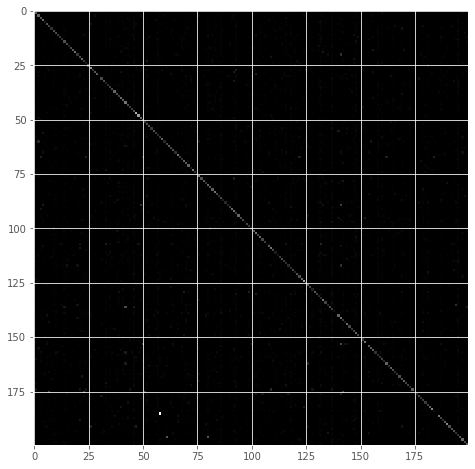

0.638668608728489


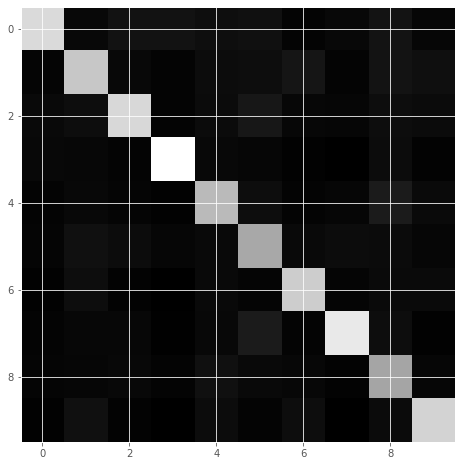

In [60]:
from prob_mat import probability_matrix
from prob_mat import count_matrix

prob_mat = probability_matrix(df_rentals)
count_mat = count_matrix(df_rentals)

print(np.sum(np.diag(count_mat))/np.sum(count_mat))

plt.imshow(prob_mat, 'gray')
plt.show()

# top N
N = 10
count_sum = np.sum(count_mat, axis=1)
idx = count_sum.argsort()[-10:][::-1]

count_max = np.zeros((N,N))
for i in range(N): # rows
    for j in range(N): # cols
        count_max[i,j] = count_mat[idx[i],idx[j]]
        
print(np.sum(np.diag(count_max))/np.sum(count_max))
prob_max = count_max/np.sum(count_max, axis=1)
plt.imshow(prob_max, 'gray')
plt.show()
#print(count_max)
#print(prob_max)

In [104]:
df_existing_hubs.id.nunique()

1091

In [93]:
def cycle_encoder(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [34]:
def helper2(time):
        #date_string=time[0:10]
        #date=datetime.date(*map(int,(date_string.split("-"))))
        return time.weekday()
    
def helper3(time):
    return time.month

def helper4(time):
    return str(time.date())

def helper5(time):
    return  time.hour

    

weekday=df_rentals.created_at.apply(helper2)
month=df_rentals.created_at.apply(helper3)
Day=df_rentals.created_at.apply(helper4)
hour=df_rentals.created_at.apply(helper5)

df_rentals = df_rentals.assign(weekday=weekday)
df_rentals = df_rentals.assign(month=month)
df_rentals = df_rentals.assign(Day=Day)
df_rentals = df_rentals.assign(hour=hour)

df_rentals = cycle_encoder(df_rentals, 'weekday', 7)
df_rentals = cycle_encoder(df_rentals, 'month', 12)
df_rentals = cycle_encoder(df_rentals, 'hour', 24)

def latitude(zone):
    return centroids_list[zone][1]

def longitude(zone):
    return centroids_list[zone][0]

Centroids_lat_pickup = df_rentals.pickup_zone.apply(latitude)
Centroids_long_pickup = df_rentals.pickup_zone.apply(longitude)
Centroids_lat_dropoff = df_rentals.dropoff_zone.apply(latitude)
Centroids_long_dropoff = df_rentals.dropoff_zone.apply(longitude)
df_rentals = df_rentals.assign(Centroids_lat_pickup=Centroids_lat_pickup)
df_rentals = df_rentals.assign(Centroids_long_pickup=Centroids_long_pickup)
df_rentals = df_rentals.assign(Centroids_lat_dropoff=Centroids_lat_dropoff)
df_rentals = df_rentals.assign(Centroids_long_dropoff=Centroids_long_dropoff)

df_rentals=df_rentals.merge(df_weather[['Day','air_temperature','rain_duration','rain_intensity','GHI']],how='left',on='Day')



In [35]:
import math
print(df_rentals.shape)
df_rentals=df_rentals.dropna()
df_rentals.head(40)

(179774, 25)


,created_at,finished_at,pickup_hub_id,dropoff_hub_id,user_id,pickup_zone,dropoff_zone,weekday,month,Day,...,hour_sin,hour_cos,Centroids_lat_pickup,Centroids_long_pickup,Centroids_lat_dropoff,Centroids_long_dropoff,air_temperature,rain_duration,rain_intensity,GHI
10,2018-03-04 11:12:20.733411,2018-03-04 16:23:29.234000,114,2155.0,114097,94,36,6,3,2018-03-04,...,2.588190e-01,-9.659258e-01,55.682141,12.534509,55.679167,12.581372,-1.683483,-0.348396,-0.302223,-0.670887
11,2018-03-04 13:33:21.954977,2018-03-04 16:43:11.438000,1513,2162.0,114156,11,50,6,3,2018-03-04,...,-2.588190e-01,-9.659258e-01,55.682547,12.583525,55.684567,12.569976,-1.683483,-0.348396,-0.302223,-0.670887
12,2018-03-04 11:02:43.910832,2018-03-04 16:53:52.803000,1736,1736.0,113665,19,19,6,3,2018-03-04,...,2.588190e-01,-9.659258e-01,55.670998,12.564478,55.670998,12.564478,-1.683483,-0.348396,-0.302223,-0.670887
16,2018-03-04 14:11:49.408975,2018-03-05 14:07:54.927000,2259,1722.0,114033,79,48,6,3,2018-03-04,...,-5.000000e-01,-8.660254e-01,55.670920,12.553993,55.676404,12.539858,-1.683483,-0.348396,-0.302223,-0.670887
17,2018-03-05 15:09:25.607536,2018-03-05 18:26:15.127000,2227,2227.0,112403,24,24,0,3,2018-03-05,...,-7.071068e-01,-7.071068e-01,55.673523,12.573642,55.673523,12.573642,-1.467062,0.221864,0.932989,-0.969043
18,2018-03-05 19:36:10.465740,2018-03-05 20:08:05.639261,2413,2226.0,85556,57,57,0,3,2018-03-05,...,-9.659258e-01,2.588190e-01,55.661660,12.564447,55.661660,12.564447,-1.467062,0.221864,0.932989,-0.969043
19,2018-03-06 07:45:32.192047,2018-03-06 08:09:27.571000,2150,1622.0,1,30,93,1,3,2018-03-06,...,9.659258e-01,-2.588190e-01,55.672324,12.589374,55.666707,12.579448,-1.068162,-0.355684,-0.302223,-0.019067
20,2018-03-04 10:22:36.055894,2018-03-06 09:32:51.417745,1732,1857.0,114088,72,50,6,3,2018-03-04,...,5.000000e-01,-8.660254e-01,55.687444,12.560642,55.684567,12.569976,-1.683483,-0.348396,-0.302223,-0.670887
21,2018-03-04 12:39:20.639575,2018-03-06 12:20:45.264094,1737,60.0,114149,33,50,6,3,2018-03-04,...,1.224647e-16,-1.000000e+00,55.700587,12.532239,55.684567,12.569976,-1.683483,-0.348396,-0.302223,-0.670887
22,2018-03-06 11:08:30.367733,2018-03-06 12:45:54.777422,2147,2150.0,114317,52,30,1,3,2018-03-06,...,2.588190e-01,-9.659258e-01,55.663308,12.603217,55.672324,12.589374,-1.068162,-0.355684,-0.302223,-0.019067


In [36]:
#df_rentals.to_pickle('DR_Data/rentals.pickle')
print(max(df_rentals.hour))
print('saved')

23
saved


In [37]:
from math import sin, cos, sqrt, atan2
def distance(z1,z2):
    R = 6373.0
    lat1=z1[0]
    lon1=z1[1]
    lat2=z2[0]
    lon2=z2[1]
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return (R * c)**2

Euc_distances_sq=np.zeros((len(centroids_list),len(centroids_list)))

for i in range(len(centroids_list)):
    for j in range(len(centroids_list)):
        Euc_distances_sq[i][j]=distance(centroids_list[i],centroids_list[j])

#np.save('DR_Data/Zone_distances',Euc_distances_sq,allow_pickle=True)

print(Euc_distances)
print(np.exp(Euc_distances))

NameError: name 'Euc_distances' is not defined